In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
import sys
print(sys.executable)

/home/rz4983/miniconda3/bin/python


In [15]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

In [16]:
device = 'cuda'

In [17]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

torch.manual_seed(42)

from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [18]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [19]:
first_piece['timestamps'] = first_piece.index
first_piece

/tmp/ipykernel_441324/4257701824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_piece['timestamps'] = first_piece.index


,O2_avg,timestamps
2017-07-11 14:00:00,244.479760,2017-07-11 14:00:00
2017-07-11 14:05:00,245.013691,2017-07-11 14:05:00
2017-07-11 14:10:00,246.106549,2017-07-11 14:10:00
2017-07-11 14:15:00,244.890977,2017-07-11 14:15:00
2017-07-11 14:20:00,244.949879,2017-07-11 14:20:00
...,...,...
2017-07-12 05:40:00,237.429344,2017-07-12 05:40:00
2017-07-12 05:45:00,237.754546,2017-07-12 05:45:00
2017-07-12 05:50:00,237.742503,2017-07-12 05:50:00
2017-07-12 05:55:00,237.609201,2017-07-12 05:55:00


In [20]:
ds_one = PandasDataset(dataframes=first_piece, freq='5min', target='O2_avg', timestamp='timestamps')

In [21]:
# training_data, test_gen = split(ds_one, offset=-36)
# test_data = test_gen.generate_instances(prediction_length=12, windows=3)

# # Train the model and make predictions
# model = DeepAREstimator(
#     prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 5}
# ).train(training_data)

# forecasts = list(model.predict(test_data.input))

# # Plot predictions
# plt.plot(df["1954":], color="black")
# for forecast in forecasts:
#   forecast.plot()
# plt.legend(["True values"], loc="upper left", fontsize="xx-large")
# plt.show()

In [22]:
# def highlight_entry(entry, color):
#     start = entry["start"]
#     end = entry["start"] + len(entry["target"])
#     plt.axvspan(start, end, facecolor=color, alpha=0.2)


# def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
#     for original_entry, train_entry in zip(original_dataset, training_dataset):
#         original_entry.plot()
#         highlight_entry(train_entry, "red")
#         plt.legend(["sub dataset", "training dataset"], loc="upper left")
#         plt.show()

#     for original_entry in original_dataset:
#         for test_input, test_label in test_pairs:
#             original_entry.plot()
#             highlight_entry(test_input, "green")
#             highlight_entry(test_label, "blue")
#             plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
#             plt.show()

In [23]:
from gluonts.dataset.util import to_pandas

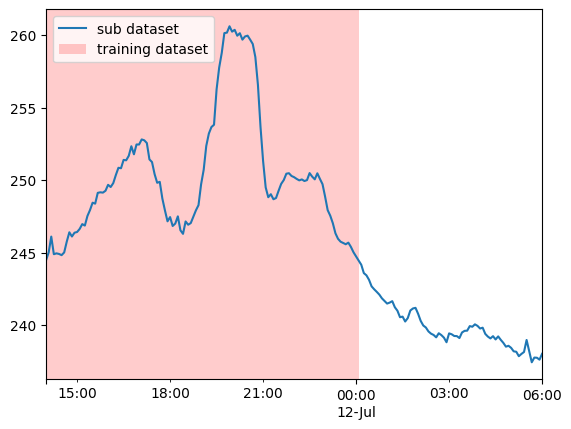

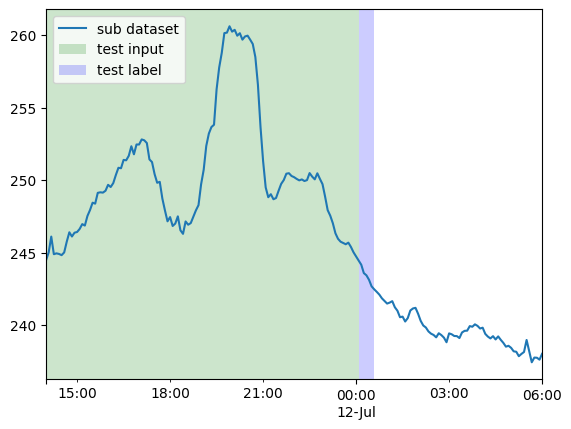

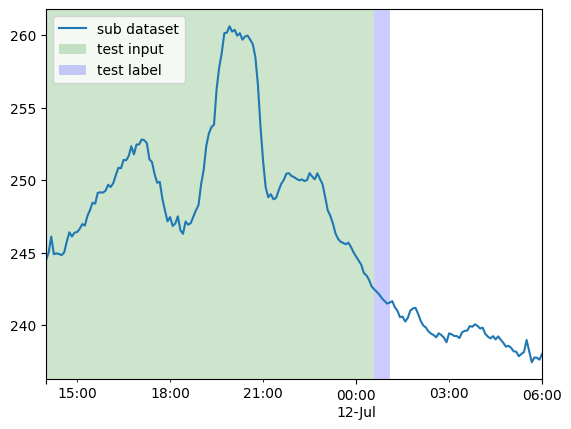

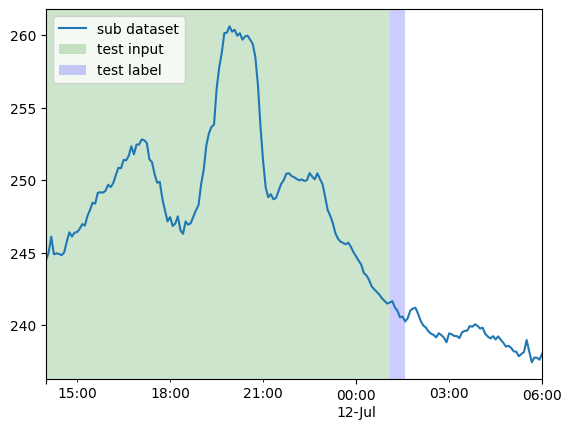

In [24]:
ds_one = PandasDataset(dataframes=first_piece, freq='5min', target='O2_avg', timestamp='timestamps')
def _to_datetime_index(s_or_df):
    obj = s_or_df.copy()
    if isinstance(obj.index, pd.PeriodIndex):
        obj.index = obj.index.to_timestamp()  # cast to DatetimeIndex
    return obj

def highlight_entry(entry, color):
    # entry["start"] is a pandas.Period, entry["target"] is an array-like
    start_period = entry["start"]
    n = int(len(entry["target"]))
    # left = start of the first period, right = start of the period AFTER the last step
    left = start_period.to_timestamp()
    right = (start_period + n).to_timestamp()
    plt.axvspan(left, right, facecolor=color, alpha=0.2)

def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        s = _to_datetime_index(to_pandas(original_entry))
        ax = s.plot()
        highlight_entry(train_entry, "red")
        ax.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            s = _to_datetime_index(to_pandas(original_entry))
            ax = s.plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            ax.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()
            
prediction_length = 6 # Preditct next 30 minutes
training_dataset, test_template = split(
    ds_one, date=pd.Period("2017-07-12 00:00:00", freq="5min")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=3,
)

training_dataset
plot_dataset_splitting(ds_one, training_dataset, test_pairs)

In [ ]:
estimator = DeepAREstimator(
    freq="5min",
    prediction_length=prediction_length,
    trainer_kwargs={"max_epochs": 50}
)

predictor = estimator.train(training_dataset)

In [26]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
first_pair = next(iter(test_pairs))
second_pair = next(iter(test_pairs))
third_pair = next(iter(test_pairs))

forecast_it, ts_it = make_evaluation_predictions(
    dataset=first_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)


/home/rz4983/miniconda3/lib/python3.12/site-packages/gluonts/torch/util.py:205: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  return a[idx]
Running evaluation: 2it [00:00,  3.89it/s]
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: co

/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


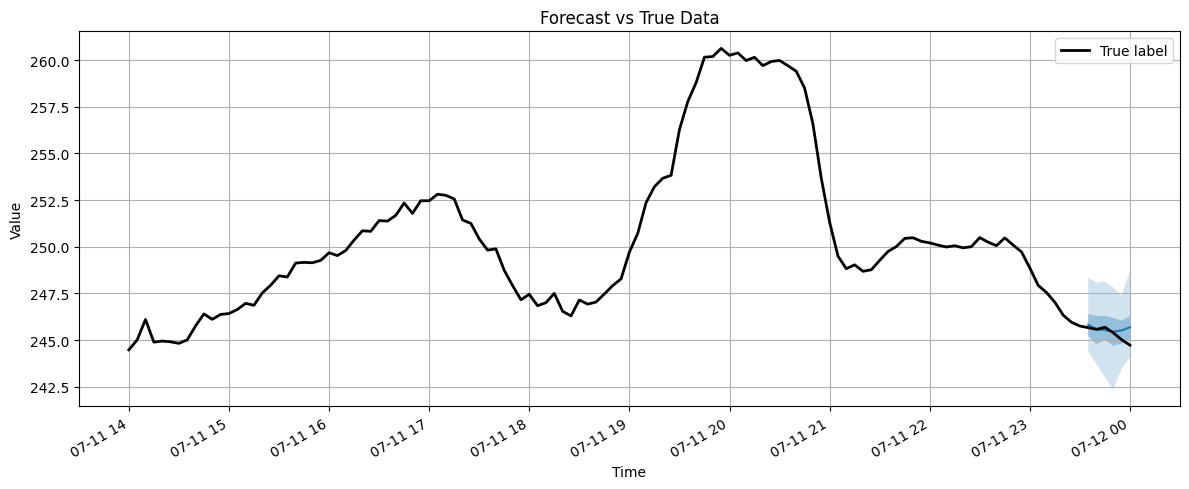

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


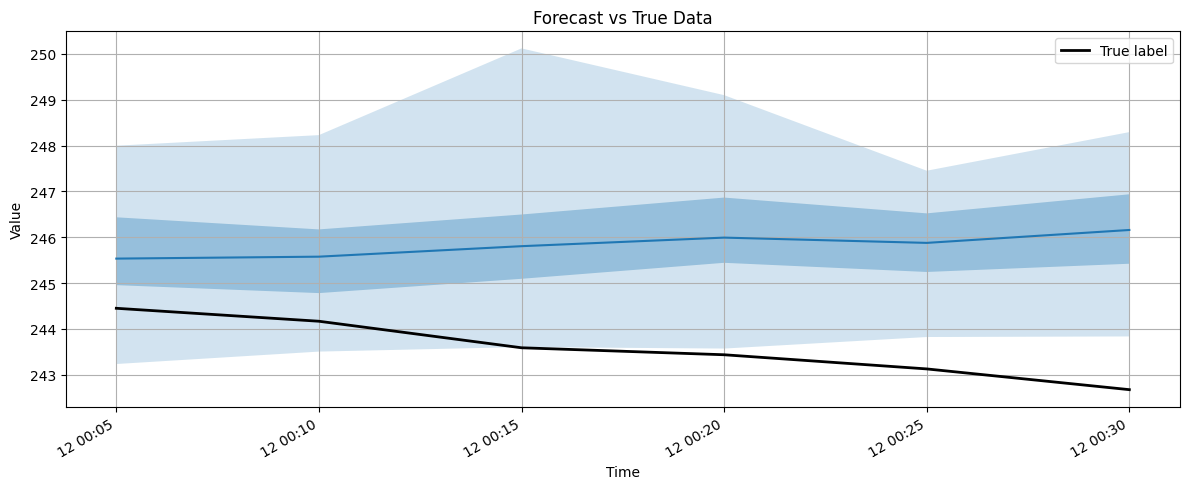

In [28]:
# Select forecast and label
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/rz4983/miniconda3/lib/python3.12/site-packages/gluonts/torch/util.py:205: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  return a[idx]
Running evaluation: 2it [00:00,  4.32it/s]
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: co

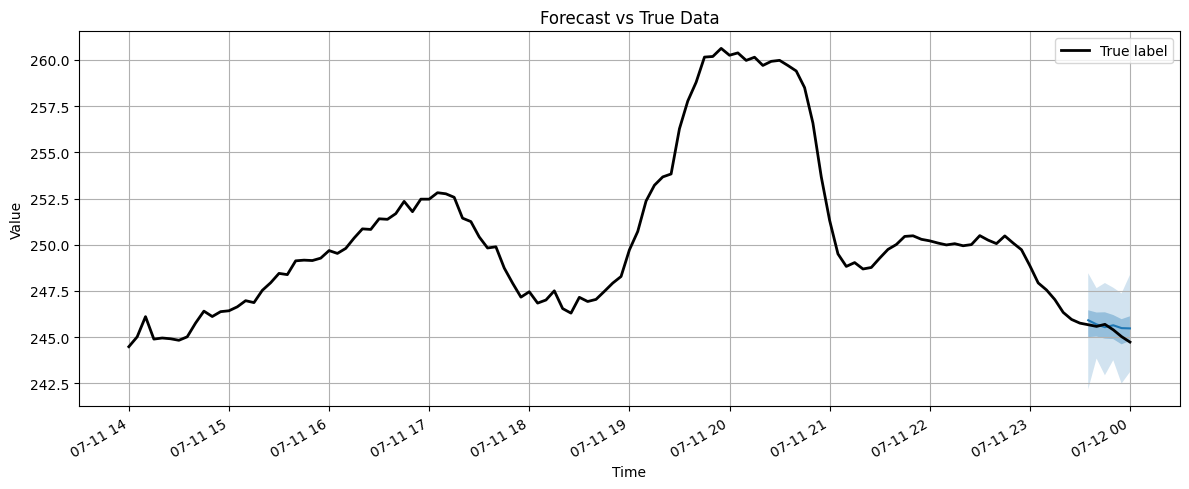

In [29]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=second_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


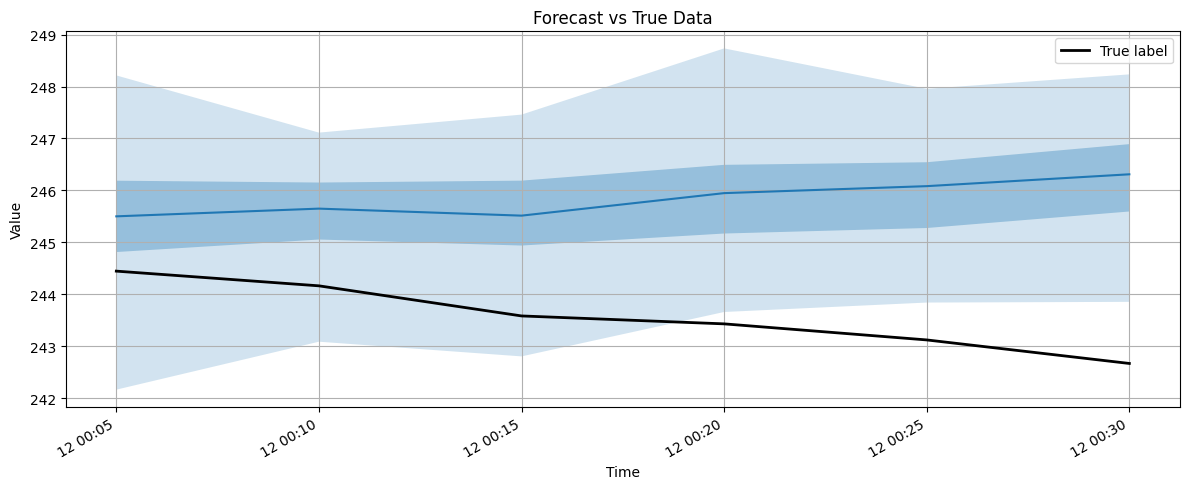

In [30]:
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

/home/rz4983/miniconda3/lib/python3.12/site-packages/gluonts/torch/util.py:205: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  return a[idx]
Running evaluation: 2it [00:00,  4.31it/s]
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/core/dtypes/astype.py:133: UserWarning: Warning: co

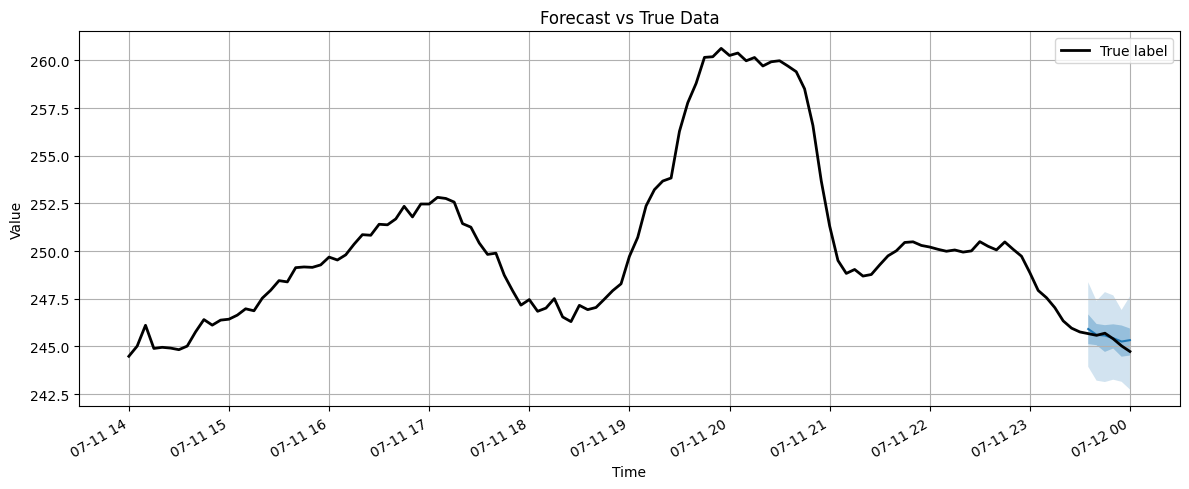

In [31]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=third_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)

# Select forecast and label
fcst = forecasts[0]
label = labels[0]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


/home/rz4983/miniconda3/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


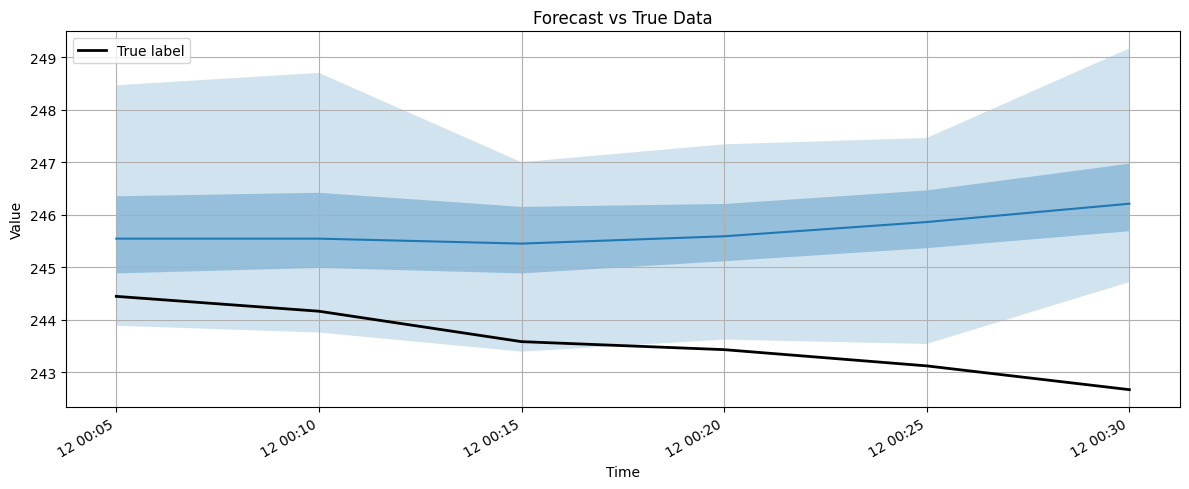

In [32]:
fcst = forecasts[1]
label = labels[1]

# Convert label to a Series if it's a DataFrame
if isinstance(label, pd.DataFrame):
    label = label.iloc[:, 0]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot forecast mean and intervals (no argument needed or use the new one)
fcst.plot(ax=ax)  # or: fcst.plot(ax=ax, prediction_intervals_percentiles=(50, 90))

# Overlay the true label on the same axis
label.plot(ax=ax, label="True label", color="black", linewidth=2)

# Formatting
ax.set_title("Forecast vs True Data")
ax.set_xlabel("Time")
ax.set_ylabel("Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()